# Baseline method

In this notebook we train a basic shallow neural network (SNN) to predict fatigue rates based on `10-min` stats of accelerations to serve as a baseline for the autoencoder method.

## Data loading

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from config import settings
from src.data import datamodule as dm
from pathlib import Path
from src.model.transformation import (FromBuffer , 
                                      CutPSD, LogTransform , NormLayer , SqueezeLayer,
                                      UnsqueezeLayer)


import matplotlib.pyplot as plt
from torch import nn 
from src.data.utils import print_database_overview, load_all_from_db 


In [3]:
db_path = Path(settings.path.processed, 'norther.db')
assert db_path.exists(), f"Database not found at {db_path}"
print_database_overview(db_path)
meta_data = load_all_from_db(db_path, 'metadata')
frequency_axis = FromBuffer()(meta_data.loc[0,'frequency_axis'])

SQLite Database Overview
Table: processed_data - id, timestamp, turbine_name, Welch_X, Welch_Y, Welch_Z, RMS_X, RMS_Y, RMS_Z, RollingAverage_X, RollingAverage_Y, RollingAverage_Z, Range_X, Range_Y, Range_Z, Mean_X, Mean_Y, Mean_Z
Table: sqlite_sequence - name, seq
Table: metadata - frequency_axis, sample_rate, window_size, processing_method
Table: scada - timestamp, mean_windspeed, min_windspeed, max_windspeed, std_windspeed, mean_yaw, min_yaw, max_yaw, std_yaw, mean_power, min_power, max_power, std_power, mean_pitch, min_pitch, max_pitch, std_pitch, mean_rpm, min_rpm, max_rpm, std_rpm, mean_winddirection, min_winddirection, max_winddirection, std_winddirection, mean_NAC_ACC_Z, min_NAC_ACC_Z, max_NAC_ACC_Z, rms_NAC_ACC_Z, rms1p_NAC_ACC_Z, mean_NAC_ACC_FA, min_NAC_ACC_FA, max_NAC_ACC_FA, rms_NAC_ACC_FA, rms1p_NAC_ACC_FA, mean_NAC_ACC_SS, min_NAC_ACC_SS, max_NAC_ACC_SS, rms_NAC_ACC_SS, rms1p_NAC_ACC_SS, mean_ti, pred_Mtn_legacy, relative_wind_dir, pred_Mtn_dnn, Mean_muY, CoV, std_NAC_ACC

In [4]:
import sqlite3
import pandas as pd

# Connect to the SQLite database
conn = sqlite3.connect(db_path)

# Collect fleet leaders
fleet_leader_list = ", ".join([f"'{t}'" for t in settings.norther.fleet_leader])

# Step 1: Fetch column metadata from the scada table
query_columns = "PRAGMA table_info(scada)"  # Retrieves metadata about the table
columns_info = pd.read_sql_query(query_columns, conn)

# Step 2: Filter columns containing 'NAC_ACC' (programmatic filtering in Python)
filtered_columns = columns_info[columns_info['name'].str.contains('NAC_ACC')]['name'].tolist()

# Step 3: Use the filtered columns in the SELECT clause dynamically
columns_str = ", ".join([f"s.{col}" for col in filtered_columns])  # Prepare column string for SQL

# Step 4: Construct the final query
query = f"""
SELECT 
    p.timestamp, 
    p.turbine_name, 
    {columns_str},
    s.DEM5_TP_SG_LAT014_Mtn
FROM 
    processed_data p
LEFT JOIN 
    scada s
ON 
    p.timestamp = s.timestamp 
    AND p.turbine_name = s.turbine_name
WHERE
    p.turbine_name IN ({fleet_leader_list})
"""

# Execute the query
merged_data = pd.read_sql_query(query, conn)
merged_data.dropna(how='all',axis=1,inplace=True)
merged_data.dropna(inplace=True)

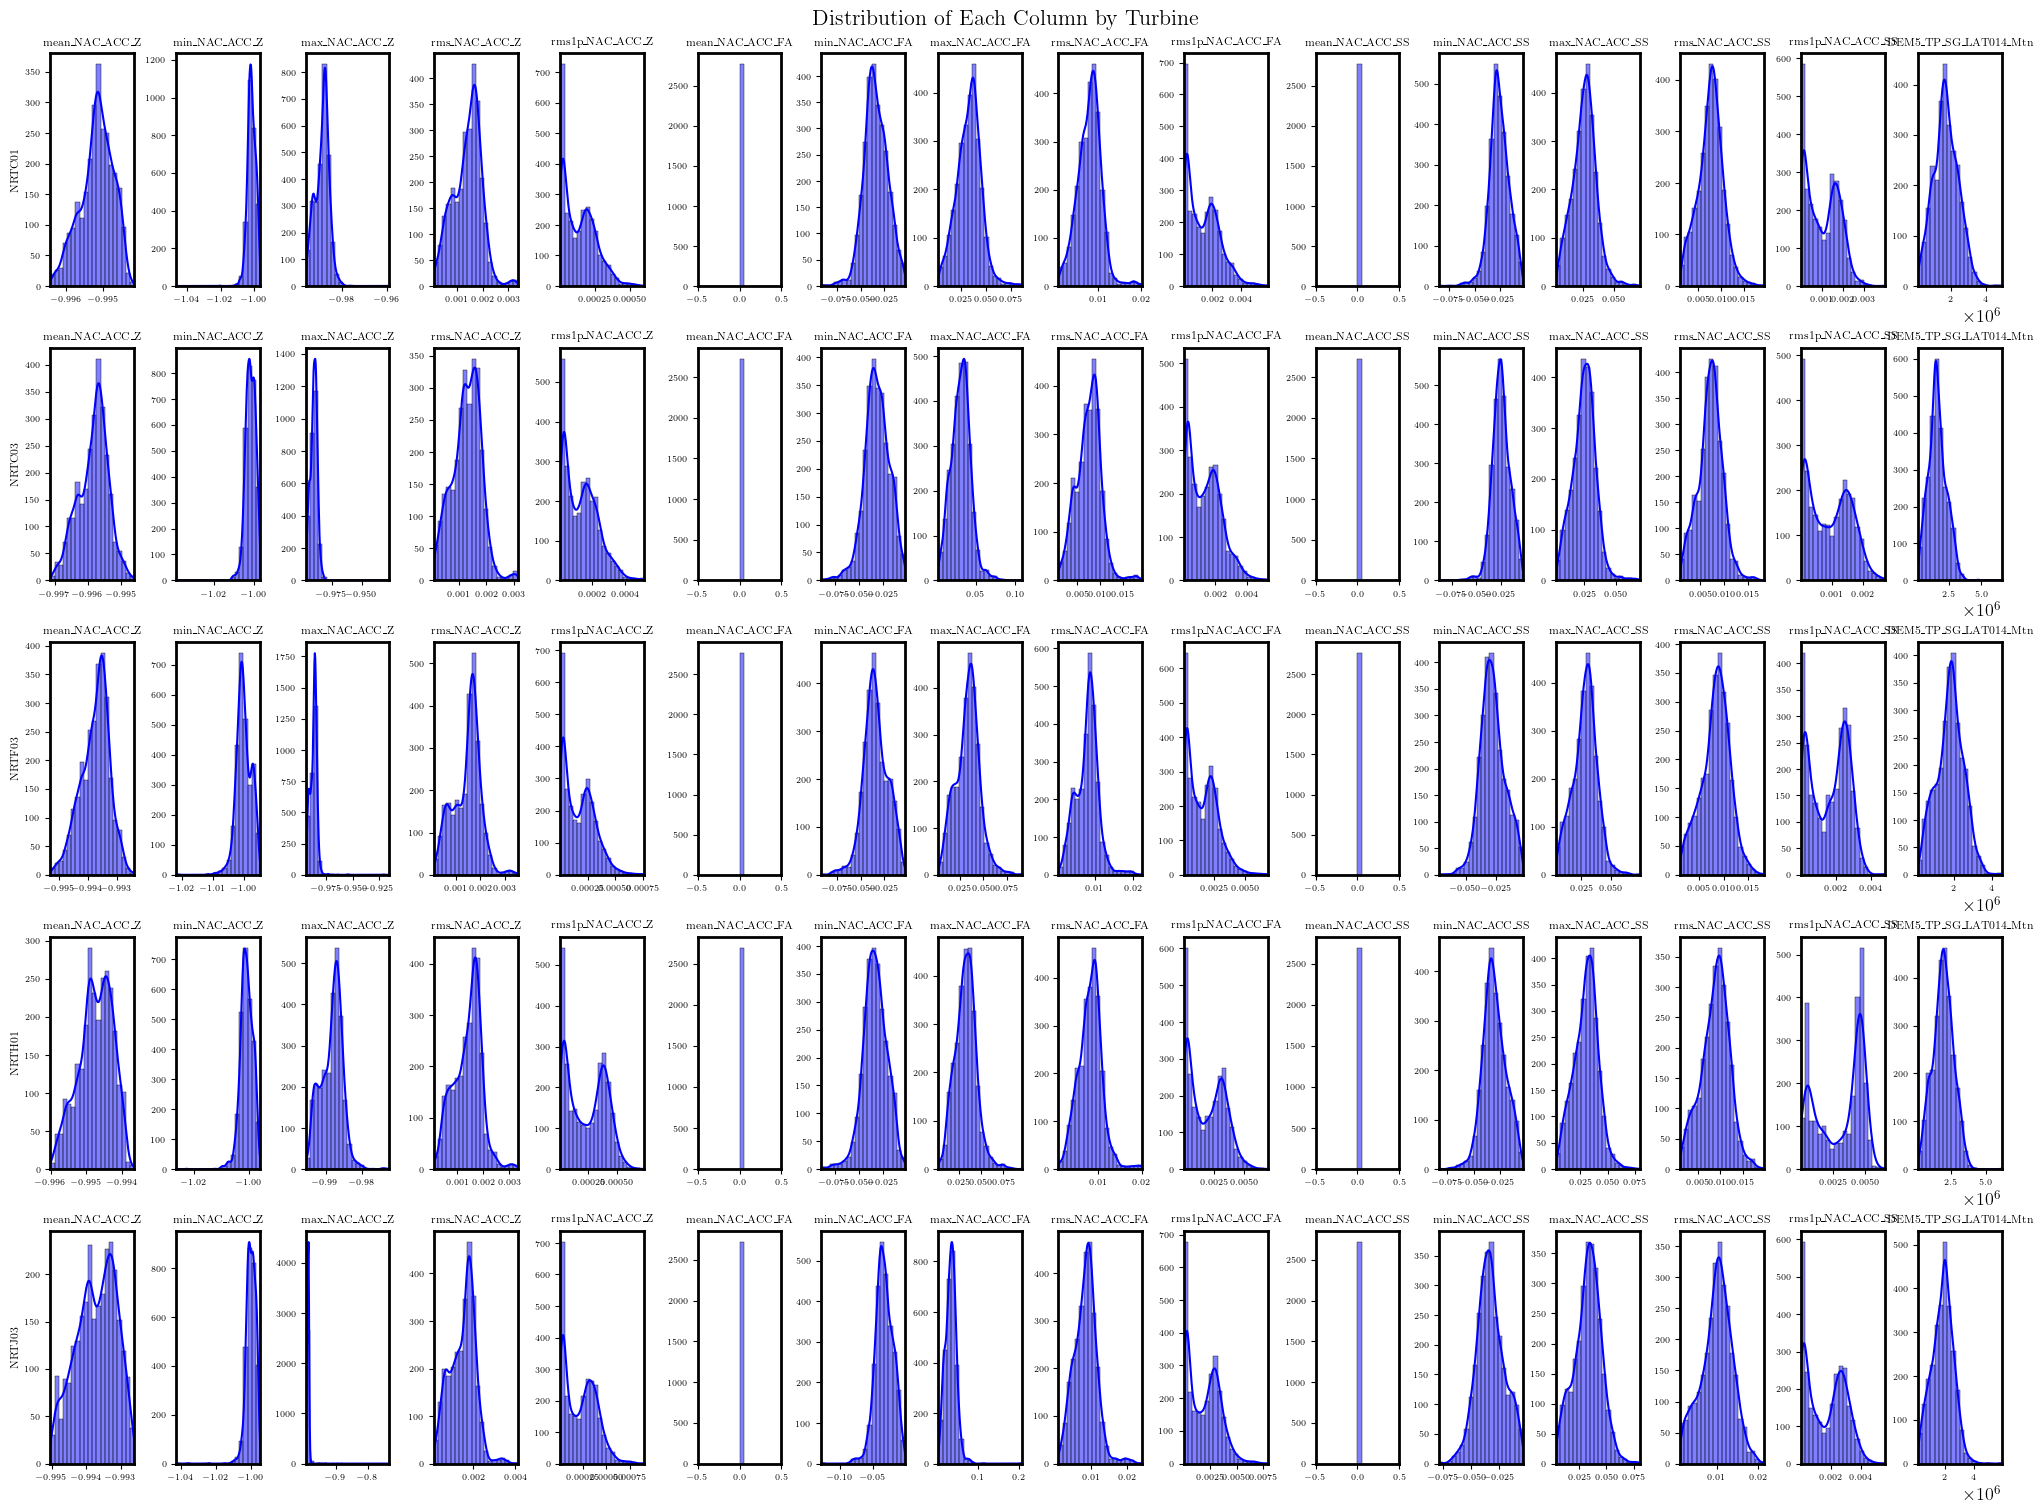

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Unique turbines in the dataset
turbines = merged_data['turbine_name'].unique()
columns = merged_data.columns.drop(['timestamp', 'turbine_name'])  # Exclude unnecessary columns

# Number of rows = number of turbines, Number of columns = number of features
num_turbines = len(turbines)
num_columns = len(columns)

# Create subplots
fig, axes = plt.subplots(num_turbines, num_columns, figsize=(20, 15), constrained_layout=True)

# Loop through turbines and columns
for i, turbine in enumerate(turbines):
    turbine_data = merged_data[merged_data['turbine_name'] == turbine]
    for j, column in enumerate(columns):
        ax = axes[i, j]
        sns.histplot(turbine_data[column], kde=True, ax=ax, bins=20, color='blue', edgecolor='black')
        ax.set_title(f"{column}", fontsize=8)
        ax.tick_params(axis='x', labelsize=6)
        ax.tick_params(axis='y', labelsize=6)
        ax.set_xlabel('')
        ax.set_ylabel('')
    axes[i, 0].set_ylabel(f"{turbine}", fontsize=8)

# Add labels and titles
fig.suptitle('Distribution of Each Column by Turbine', fontsize=16)
plt.show()


In [7]:
train_columns = ['mean_NAC_ACC_Z',
 'min_NAC_ACC_Z',
 'max_NAC_ACC_Z',
 'rms_NAC_ACC_Z',
 'rms1p_NAC_ACC_Z',
 'mean_NAC_ACC_FA',
 'min_NAC_ACC_FA',
 'max_NAC_ACC_FA',
 'rms_NAC_ACC_FA',
 'rms1p_NAC_ACC_FA',
 'mean_NAC_ACC_SS',
 'min_NAC_ACC_SS',
 'max_NAC_ACC_SS',
 'rms_NAC_ACC_SS',
 'rms1p_NAC_ACC_SS',
 'DEM5_TP_SG_LAT014_Mtn']
# we remove the mean_NAC_ACC_FA because it is constant
train_columns.remove('mean_NAC_ACC_FA')
# we remove the mean_NAC_ACC_SS because it is constant
train_columns.remove('mean_NAC_ACC_SS')

R² Score: 0.6968
Mean Absolute Error: 272322.5535
Relative Error: 16.9237%


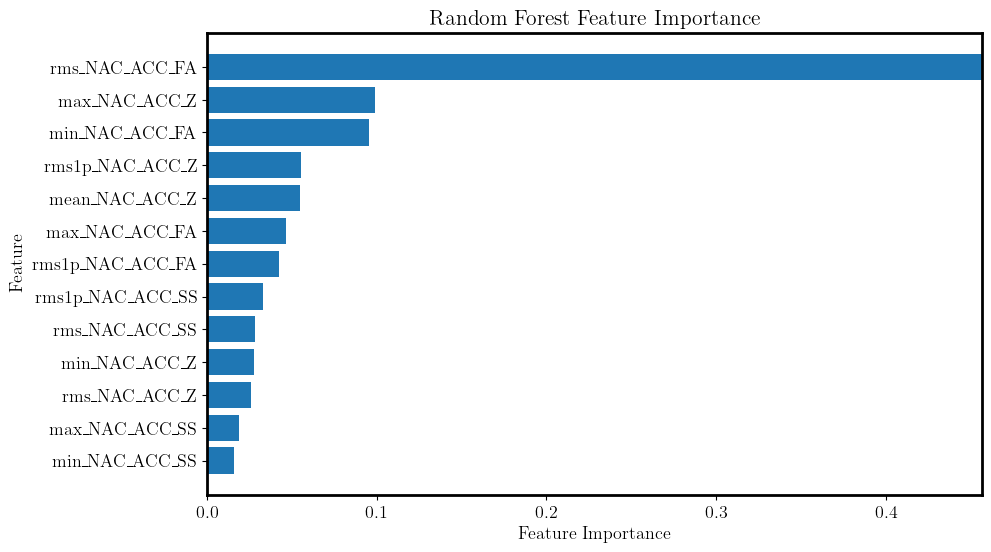

In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
import numpy as np
# Step 1: Prepare features and target
train_data = merged_data.query(f"turbine_name in {settings.norther.fleet_leader[:2]}")
features = train_data[train_columns[:-1]]  # Exclude the target column
target = train_data['DEM5_TP_SG_LAT014_Mtn']

# Step 2: Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Step 3: Train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=10, random_state=42)
rf_model.fit(X_train, y_train)

# Step 4: Make predictions
y_pred = rf_model.predict(X_test)

# Step 5: Evaluate the model
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
relative_error = np.mean(np.abs((y_test - y_pred) / y_test))

print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Relative Error: {relative_error:.4%}")

# Optional: Feature importance visualization
import matplotlib.pyplot as plt

feature_importances = rf_model.feature_importances_
sorted_idx = np.argsort(feature_importances)
plt.figure(figsize=(10, 6))
plt.barh(np.array(train_columns[:-1])[sorted_idx], feature_importances[sorted_idx])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Random Forest Feature Importance")
plt.show()


In [9]:
merged_data['dem5_pred'] = rf_model.predict(merged_data[train_columns[:-1]].values)

/home/owilab/Documents/YacineB/Code/damage_prediction_AE/.venv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [10]:
merged_data['turbine_name'].unique()

array(['NRTC01', 'NRTC03', 'NRTF03', 'NRTH01', 'NRTJ03'], dtype=object)

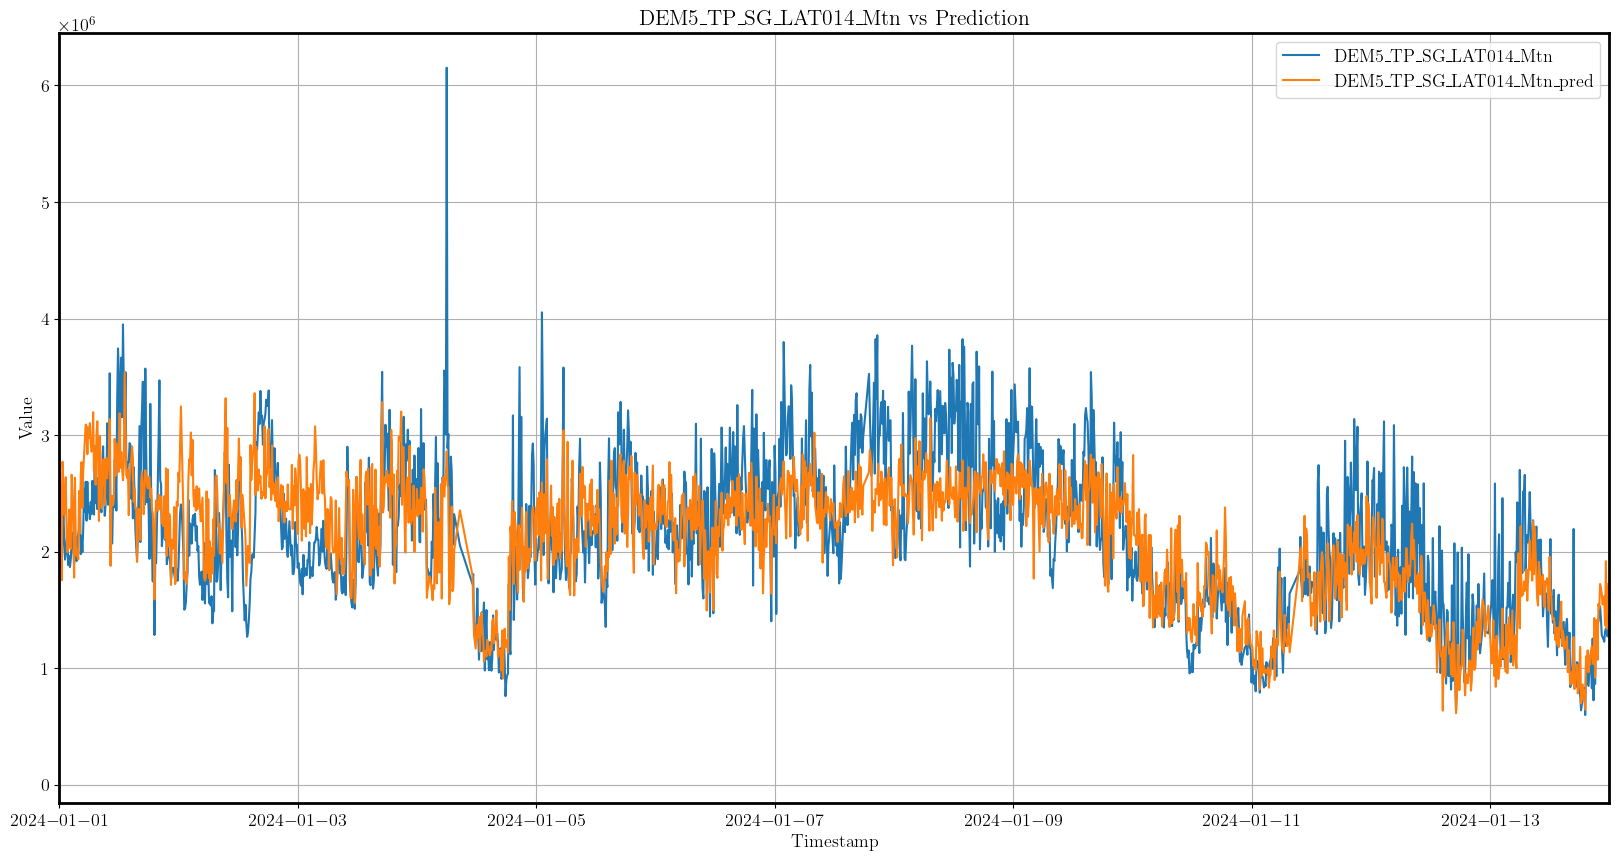

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure the timestamp column is in datetime format
merged_data['timestamp'] = pd.to_datetime(merged_data['timestamp'])
merged_data.sort_values(by='timestamp', inplace=True)
df_turb = merged_data[merged_data['turbine_name'] == 'NRTH01']

# Define the x-axis limits as datetime objects
start_date = pd.Timestamp('2024-01-01')
end_date = pd.Timestamp('2024-01-14')

# Plot the data
plt.figure(figsize=(20, 10))
plt.plot(df_turb['timestamp'], df_turb['DEM5_TP_SG_LAT014_Mtn'], label='DEM5_TP_SG_LAT014_Mtn')
plt.plot(df_turb['timestamp'], df_turb['dem5_pred'], label='DEM5_TP_SG_LAT014_Mtn_pred')
plt.xlim(start_date, end_date)  # Use datetime objects for limits
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.title('DEM5_TP_SG_LAT014_Mtn vs Prediction')
plt.grid(True)
plt.show()


In [ ]:
from src.evaluation.metric import r2_score, relative_err
merged_data.groupby('turbine_name').apply(lambda x: relative_err(x['DEM5_TP_SG_LAT014_Mtn'], x['dem5_pred']))

/tmp/ipykernel_949504/3441298205.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  merged_data.groupby('turbine_name').apply(lambda x: r2_score(x['DEM5_TP_SG_LAT014_Mtn'], x['dem5_pred']))


turbine_name
NRTC01    0.896738
NRTC03    0.901311
NRTF03    0.547578
NRTH01    0.642268
NRTJ03    0.569725
dtype: float64

In [54]:
merged_data.groupby('turbine_name').apply(lambda x:np.min(x['DEM5_TP_SG_LAT014_Mtn']))

/tmp/ipykernel_949504/3204280951.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  merged_data.groupby('turbine_name').apply(lambda x:np.min(x['DEM5_TP_SG_LAT014_Mtn']))


turbine_name
NRTC01    150094.901582
NRTC03    131341.707605
NRTF03    107433.064927
NRTH01    144758.270764
NRTJ03    173903.322170
dtype: float64

In [55]:
merged_data.groupby('turbine_name').apply(lambda x:np.max(x['DEM5_TP_SG_LAT014_Mtn']))

/tmp/ipykernel_949504/200394855.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  merged_data.groupby('turbine_name').apply(lambda x:np.max(x['DEM5_TP_SG_LAT014_Mtn']))


turbine_name
NRTC01    4.884268e+06
NRTC03    6.568132e+06
NRTF03    4.520507e+06
NRTH01    6.152211e+06
NRTJ03    5.909275e+06
dtype: float64

In [13]:
from src.data.utils import get_statistic
from src.utils.rich_utils import print_stats_as_table

import numpy as np
statistics_scada = get_statistic(db_path,train_columns,
              [np.max,np.min,np.std,np.mean], 'scada',
              timestamp_range=('2023-01-01', '2024-01-01'),
              add_condition= f"turbine_name in ({fleet_leader_list})")
# let's apply a log transformation to the statistics that contain 'Welch' 
for key,item in statistics_scada.items():
    if 'Welch' in key:
        for stat,values in item.items():
            item[stat] = np.log(values)
print_stats_as_table(statistics_scada)



Query: SELECT mean_NAC_ACC_Z, min_NAC_ACC_Z, max_NAC_ACC_Z, rms_NAC_ACC_Z, rms1p_NAC_ACC_Z, min_NAC_ACC_FA, max_NAC_ACC_FA, rms_NAC_ACC_FA, rms1p_NAC_ACC_FA, min_NAC_ACC_SS, max_NAC_ACC_SS, rms_NAC_ACC_SS, rms1p_NAC_ACC_SS, DEM5_TP_SG_LAT014_Mtn FROM scada WHERE timestamp > '2023-01-01' AND timestamp < '2024-01-01' AND turbine_name in ('NRTC01', 'NRTC03', 'NRTH01', 'NRTF03', 'NRTJ03')


                  Statistics Table                  
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Column Name           ┃ Statistic ┃        Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ mean_NAC_ACC_Z        │ max       │      -0.9924 │
│ mean_NAC_ACC_Z        │ min       │      -0.9971 │
│ mean_NAC_ACC_Z        │ std       │       0.0009 │
│ mean_NAC_ACC_Z        │ mean      │      -0.9948 │
│ min_NAC_ACC_Z         │ max       │      -0.9949 │
│ min_NAC_ACC_Z         │ min       │      -1.0205 │
│ min_NAC_ACC_Z         │ std       │       0.0025 │
│ min_NAC_ACC_Z         │ mean      │      -0.9996 │
│ max_NAC_ACC_Z         │ max       │      -0.9591 │
│ max_NAC_ACC_Z         │ min       │      -0.9968 │
│ max_NAC_ACC_Z         │ std       │       0.0033 │
│ max_NAC_ACC_Z         │ mean      │      -0.9899 │
│ rms_NAC_ACC_Z         │ max       │       0.0027 │
│ rms_NAC_ACC_Z         │ min       │       0.0001 │
│ rms_NAC_ACC_Z         │ std       │       0.0006 │
│ rms_NAC_ACC_Z         │ mean      │       0.0011 │
│ rms1p_NAC_ACC_Z       │ max       │       0.0007 │
│ rms1p_NAC_ACC_Z       │ min       │       0.0000 │
│ rms1p_NAC_ACC_Z       │ std       │       0.0001 │
│ rms1p_NAC_ACC_Z       │ mean      │       0.0001 │
│ min_NAC_ACC_FA        │ max       │      -0.0023 │
│ min_NAC_ACC_FA        │ min       │      -0.0861 │
│ min_NAC_ACC_FA        │ std       │       0.0137 │
│ min_NAC_ACC_FA        │ mean      │      -0.0271 │
│ max_NAC_ACC_FA        │ max       │       0.0828 │
│ max_NAC_ACC_FA        │ min       │       0.0023 │
│ max_NAC_ACC_FA        │ std       │       0.0133 │
│ max_NAC_ACC_FA        │ mean      │       0.0266 │
│ rms_NAC_ACC_FA        │ max       │       0.0242 │
│ rms_NAC_ACC_FA        │ min       │       0.0007 │
│ rms_NAC_ACC_FA        │ std       │       0.0033 │
│ rms_NAC_ACC_FA        │ mean      │       0.0068 │
│ rms1p_NAC_ACC_FA      │ max       │       0.0061 │
│ rms1p_NAC_ACC_FA      │ min       │       0.0000 │
│ rms1p_NAC_ACC_FA      │ std       │       0.0012 │
│ rms1p_NAC_ACC_FA      │ mean      │       0.0011 │
│ min_NAC_ACC_SS        │ max       │      -0.0024 │
│ min_NAC_ACC_SS        │ min       │      -0.0845 │
│ min_NAC_ACC_SS        │ std       │       0.0115 │
│ min_NAC_ACC_SS        │ mean      │      -0.0222 │
│ max_NAC_ACC_SS        │ max       │       0.0714 │
│ max_NAC_ACC_SS        │ min       │       0.0024 │
│ max_NAC_ACC_SS        │ std       │       0.0116 │
│ max_NAC_ACC_SS        │ mean      │       0.0223 │
│ rms_NAC_ACC_SS        │ max       │       0.0212 │
│ rms_NAC_ACC_SS        │ min       │       0.0007 │
│ rms_NAC_ACC_SS        │ std       │       0.0035 │
│ rms_NAC_ACC_SS        │ mean      │       0.0066 │
│ rms1p_NAC_ACC_SS      │ max       │       0.0065 │
│ rms1p_NAC_ACC_SS      │ min       │       0.0000 │
│ rms1p_NAC_ACC_SS      │ std       │       0.0013 │
│ rms1p_NAC_ACC_SS      │ mean      │       0.0011 │
│ DEM5_TP_SG_LAT014_Mtn │ max       │ 5475700.2678 │
│ DEM5_TP_SG_LAT014_Mtn │ min       │  107433.0649 │
│ DEM5_TP_SG_LAT014_Mtn │ std       │  743985.8472 │
│ DEM5_TP_SG_LAT014_Mtn │ mean      │ 1401611.8457 │
└───────────────────────┴───────────┴──────────────┘

In [40]:
from src.data import datamodule as dm
from src.model.transformation import ToTensor, EncoderBasedOnList
from src.model.prepared_queries import do_nothing

training_turbines = settings.norther.fleet_leader[:2]
train_transforms = [nn.Identity()] + 13 * [ToTensor()]

# Dynamically build the condition to exclude rows with NULLs
non_null_conditions = " AND ".join([f"{col} IS NOT NULL" for col in train_columns])

# Create the final query with the non-NULL condition
key_query = f"""
SELECT id 
FROM scada
WHERE turbine_name IN ('{"','".join(training_turbines)}')
  AND {non_null_conditions}
"""


data_loader_reg = dm.PSDDataModule(
    db_path=db_path,
    view_query=do_nothing,    # or any custom query that fetches Welch_*, DEM
    view_table_name='scada',
    key_query=key_query,
    key_name='id',
    columns=train_columns,
    transform_func=train_transforms,
    batch_size=64,
    cached=True,
    return_dict=True
)

data_loader_reg.setup()

In [41]:
len(data_loader_reg.train_dataset)

4394

## Training

### Model definition

In [42]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
from src.model.backbone.utils import build_layers
from src.model.transformation import MultiChannelNormalization, NormLayer, DictStack

class FeatureBasedRegressor(nn.Module):
    def __init__(self, input_list,
                 hidden_dims,
                 normalization_values,
                 batch_norm,
                 activation:str='relu',
                 output_name:str='dem5_pred',
                 target_name:str='DEM5_TP_SG_LAT014_Mtn'):
        super(FeatureBasedRegressor, self).__init__()
        self.input_list = input_list
        self.hidden_dims = hidden_dims
        self.normalization_values = normalization_values
        self.batch_norm = batch_norm
        hidden_dims_all = [len(input_list)] + hidden_dims + [1]
        activation_list =  [activation] * (len(hidden_dims) ) + [None]
        self.normalization_layer_in = MultiChannelNormalization(sensor_list=input_list,
                                                                normalization_type='minmax',
                                                                statistics=normalization_values)

        self.stack_data = DictStack(keys=input_list, dim=1, unstack=False) 
        self.net = nn.Sequential(
            nn.BatchNorm1d(len(input_list)),
            nn.Linear(len(input_list), 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            NormLayer(max_val=5475700.2678, min_val=107433.0649,denormalize=True)
        )
        self.output_name = output_name
        self.target_name = target_name
        
        
    def forward(self, x):
        """ x is a dictionary of tensors"""
        x_stack = self.stack_data(x)
        # to_float32 
        x_stack = torch.tensor(x_stack, dtype=torch.float32)
        out = (self.net(x_stack))
        x.update({self.output_name: out})
        return x

class TrainFeatureBasedRegressor(pl.LightningModule):
    def __init__(self,input_list,
                    hidden_dims,
                    normalization_values,
                    batch_norm,
                    activation,
                    output_name,
                    target_name,           
                    lr=1e-3):
        super(TrainFeatureBasedRegressor, self).__init__()
        self.model = FeatureBasedRegressor(input_list, hidden_dims, 
                                           normalization_values, batch_norm,activation=activation,
                                           output_name=output_name,
                                           target_name=target_name)
        self.save_hyperparameters(ignore='model')
        self.lr = lr
        self.loss = nn.MSELoss()
        self.target_name = target_name
        self.output_name = output_name
        
        assert not self.target_name in input_list, f"Output name {self.target_name} should not be in input list"
        
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        out = self(batch)

        loss = self.loss(out[self.output_name], out[self.target_name])
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss
    def validation_step(self, batch, batch_idx):
        out = self(batch)
        loss = self.loss(out[self.output_name], out[self.target_name])
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

In [43]:

from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping



checkpoint_reg_callback = ModelCheckpoint(
    monitor="val_loss",
    dirpath="checkpoints_regressor/",
    filename="regressor-{epoch:02d}-{val_loss:.2f}",
    save_top_k=3,
    mode="min"
)
early_stop_reg_callback = EarlyStopping(
    monitor="val_loss",
    patience=20,
    mode="min"
)
tensorboard_logger = pl.loggers.TensorBoardLogger(settings.path.tensorboard) 

trainer_reg = pl.Trainer(
    max_epochs=100, 
    accelerator="gpu",
    devices=1,  # or "auto"
    callbacks=[checkpoint_reg_callback, early_stop_reg_callback],
    logger=tensorboard_logger,
)
regressor_model = TrainFeatureBasedRegressor(input_list=train_columns[:-1],
                                                hidden_dims=[64,128,8],
                                                normalization_values=statistics_scada,
                                                batch_norm=False,
                                                activation='relu',
                                                output_name='dem5_pred',
                                                target_name='DEM5_TP_SG_LAT014_Mtn',
                                                lr=5e-3)

trainer_reg.fit(regressor_model, data_loader_reg)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                  | Params | Mode 
--------------------------------------------------------
0 | model | FeatureBasedRegressor | 10.1 K | train
1 | loss  | MSELoss               | 0      | train
--------------------------------------------------------
10.1 K    Trainable params
0         Non-trainable params
10.1 K    Total params
0.041     Total estimated model params size (MB)
26        Modules in train mode
0         Modules in eval mode


Already set


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/tmp/ipykernel_949504/204111266.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_stack = torch.tensor(x_stack, dtype=torch.float32)
/home/owilab/Documents/YacineB/Code/damage_prediction_AE/.venv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Training: |          | 0/? [00:00<?, ?it/s]

/home/owilab/Documents/YacineB/Code/damage_prediction_AE/.venv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([42])) that is different to the input size (torch.Size([42, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Validation: |          | 0/? [00:00<?, ?it/s]

/home/owilab/Documents/YacineB/Code/damage_prediction_AE/.venv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([11, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [56]:
# Iterate through the training dataloader to inspect the model's behavior
for batch in data_loader_reg.train_dataloader():
    # Print the raw input data for 'rms_NAC_ACC_Z'
    print("Raw input data (rms_NAC_ACC_Z):")
    print(batch['rms_NAC_ACC_Z'].shape)  # Check the shape of the input tensor
    print(batch['rms_NAC_ACC_Z'])  # Print the actual values

    # Apply normalization to the batch
    norm_data = regressor_model.model.normalization_layer_in(batch)
    print("\nNormalized data (rms_NAC_ACC_Z):")
    print(norm_data['rms_NAC_ACC_Z'].shape)  # Check the shape after normalization
    print(norm_data['rms_NAC_ACC_Z'])  # Print the normalized values

    # Stack the normalized data along the feature dimension
    stack = regressor_model.model.stack_data(norm_data)
    print("\nStacked data (all features):")
    print(stack.shape)  # Check the shape of the stacked tensor
    print(stack)  # Print the stacked data

    # Print the progression through the model's layers
    print("\nProgression through the model layers:")
    stack = torch.tensor(stack, dtype=torch.float32)

    for i, layer in enumerate(regressor_model.model.net):
        print(f"\nLayer {i + 1}: {layer}")
        stack = layer(stack)  # Apply the layer to the stacked data
        print(f"Output shape: {stack.shape}")  # Check the output shape
        print(f"Output values: {stack}")  # Print the output values

    # Break after the first batch to inspect the results
    break

Raw input data (rms_NAC_ACC_Z):
torch.Size([4000])
tensor([0.0018, 0.0021, 0.0007,  ..., 0.0017, 0.0013, 0.0016])

Normalized data (rms_NAC_ACC_Z):
torch.Size([4000])
tensor([0.6341, 0.7523, 0.2253,  ..., 0.6026, 0.4540, 0.5596])

Stacked data (all features):
torch.Size([4000, 13])
tensor([[0.2701, 0.5720, 0.3187,  ..., 0.4330, 0.3571, 0.1997],
        [0.7271, 0.7416, 0.3095,  ..., 0.4351, 0.4614, 0.3878],
        [0.6253, 0.9157, 0.1419,  ..., 0.2269, 0.2694, 0.0525],
        ...,
        [0.8655, 0.7526, 0.2821,  ..., 0.4535, 0.5337, 0.5167],
        [0.5031, 0.7909, 0.2073,  ..., 0.3096, 0.3056, 0.2512],
        [0.8128, 0.8131, 0.2442,  ..., 0.3877, 0.3923, 0.3450]],
       dtype=torch.float64)

Progression through the model layers:

Layer 1: BatchNorm1d(13, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Output shape: torch.Size([4000, 13])
Output values: tensor([[-1.0361, -1.2965,  0.4570,  ...,  0.1153, -0.4552, -0.5138],
        [ 0.6322,  0.0890,  0.3796,  ...

/tmp/ipykernel_949504/3330162454.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stack = torch.tensor(stack, dtype=torch.float32)


In [45]:
from src.data import datamodule as dm
from src.model.transformation import ToTensor, EncoderBasedOnList
from src.model.prepared_queries import do_nothing

training_turbines = settings.norther.fleet_leader
train_columns_w_timestamp = ['timestamp']+['turbine_name'] + train_columns

train_transforms = 3*[nn.Identity()] + 13 * [ToTensor()]
# Dynamically build the condition to exclude rows with NULLs
non_null_conditions = " AND ".join([f"{col} IS NOT NULL" for col in train_columns])

# Create the final query with the non-NULL condition
key_query = f"""
SELECT id 
FROM scada
WHERE turbine_name IN ('{"','".join(training_turbines)}')
  AND timestamp > '{settings.norther.training_end}'
  AND {non_null_conditions}
"""

training_turbines 
data_loader_reg = dm.PSDDataModule(
    db_path=db_path,
    view_query=do_nothing,    # or any custom query that fetches Welch_*, DEM
    view_table_name='scada',
    key_query=key_query,
    key_name='id',
    columns=train_columns_w_timestamp,
    transform_func=train_transforms,
    batch_size=4000,
    cached=True,
    return_dict=True
)

data_loader_reg.setup()

In [46]:
batch.keys()

dict_keys(['mean_NAC_ACC_Z', 'min_NAC_ACC_Z', 'max_NAC_ACC_Z', 'rms_NAC_ACC_Z', 'rms1p_NAC_ACC_Z', 'min_NAC_ACC_FA', 'max_NAC_ACC_FA', 'rms_NAC_ACC_FA', 'rms1p_NAC_ACC_FA', 'min_NAC_ACC_SS', 'max_NAC_ACC_SS', 'rms_NAC_ACC_SS', 'rms1p_NAC_ACC_SS', 'DEM5_TP_SG_LAT014_Mtn'])

In [47]:
import pandas as pd
dfs = []

# Iterate over batches from the dataloader
for batch in data_loader_reg.all_dataloader():
    # Extract relevant keys from the batch
    timestamps = batch['timestamp']
    turbine_names = batch['turbine_name']

    # Forward pass: model_all expects the batch dictionary
    with torch.no_grad():
        data = regressor_model(batch)  # batch includes all input features
    dem_pred = data['dem5_pred']
    dem = batch['DEM5_TP_SG_LAT014_Mtn']

    # Create a DataFrame for the current batch
    
    df_temp = pd.DataFrame({
        'timestamp': np.array(timestamps),
        'turbine_name': np.array(turbine_names),
        'dem': np.array(dem.cpu()),
        'dem5_pred': dem_pred.squeeze().cpu().numpy(),
    })
    dfs.append(df_temp)

# Concatenate all batch results
data = pd.concat(dfs, ignore_index=True)


/tmp/ipykernel_949504/204111266.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_stack = torch.tensor(x_stack, dtype=torch.float32)


In [48]:
data['timestamp'] = pd.to_datetime(data['timestamp'])

(np.float64(19723.0), np.float64(19736.0))

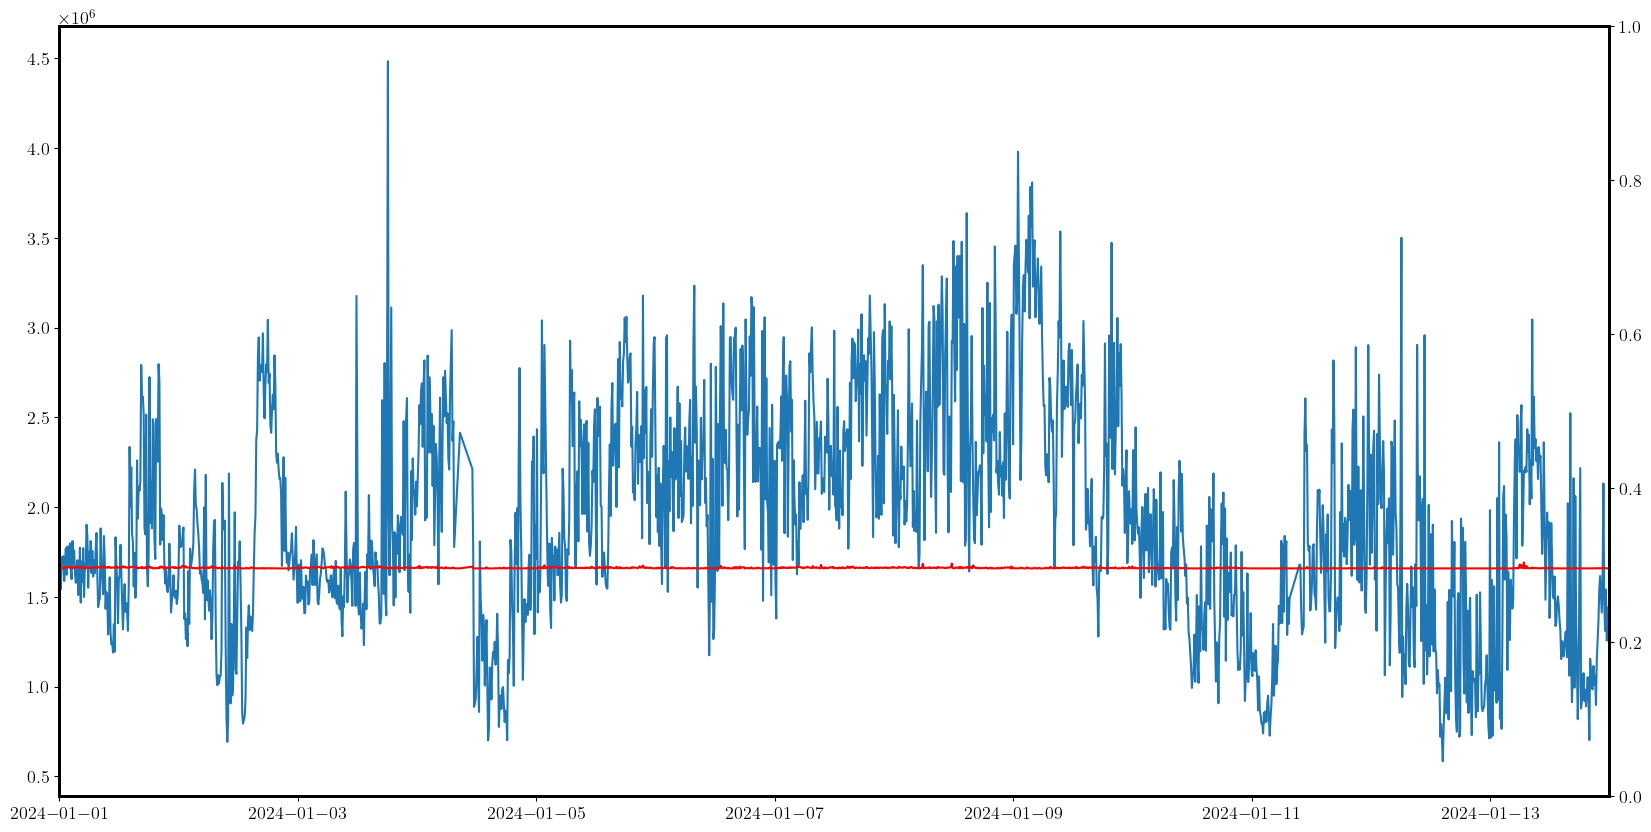

In [51]:

import matplotlib.pyplot as plt
#make the same plot for the first turbine 
df_turb = data[data['turbine_name'] == 'NRTC01']
start_date = pd.Timestamp('2024-01-01')
end_date = pd.Timestamp('2024-01-14')

# Plot the data
fig,ax= plt.subplots(figsize=(20, 10))
ax.plot(df_turb['timestamp'], df_turb['dem'], label='DEM5_TP_SG_LAT014_Mtn')
ax1 = ax.twinx()
ax.plot(df_turb['timestamp'], (df_turb['dem5_pred']), label='DEM5_TP_SG_LAT014_Mtn_pred',color='red')
plt.xlim(start_date, end_date)  # Use datetime objects for limits


In [ ]:
from src.evaluation.metric import r2_score, relative_err
data.groupby('turbine_name').apply(lambda x: r2_score(x['dem'], x['dem5_pred']))


/tmp/ipykernel_265204/2087718715.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data.groupby('turbine_name').apply(lambda x: r2_score(x['dem'], x['dem5_pred']))


turbine_name
NRTC01   -0.210389
NRTC03   -0.078920
NRTF03   -0.331599
NRTH01   -0.575980
NRTJ03   -0.417995
dtype: float32

In [135]:
data.groupby('turbine_name').apply(lambda x: relative_err(x['dem'], x['dem5_pred']))

/tmp/ipykernel_265204/1234983637.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data.groupby('turbine_name').apply(lambda x: relative_err(x['dem'], x['dem5_pred']))


turbine_name
NRTC01    0.272798
NRTC03    0.298762
NRTF03    0.288882
NRTH01    0.290617
NRTJ03    0.280870
dtype: float32